In [1]:
import math
import numpy as np
from os.path import join
import os
import subprocess
from utils import *
from skimage.measure import block_reduce

In [2]:
def plot_merged_slices(array_3d, dim, idx0, idx1):
    plt.figure(dpi=150)
    if dim=='x':  # shape of array_3d should be z,x,y
        to_show=np.max(array_3d[:,idx0:idx1,:], axis=1)
        plt.imshow(to_show, cmap='gray')  # aspect=2
    elif dim=='y':
        to_show=np.max(array_3d[:,:,idx0:idx1], axis=2)
#         to_show[to_show>2]=2
        plt.imshow(to_show, cmap='gray')
    elif dim=='z':
        to_show=np.max(array_3d[idx0:idx1,:,:], axis=0)
#         to_show[to_show>2]=2
        plt.imshow(to_show, cmap='gray')
    plt.colorbar()
    plt.show()


def reshape_and_save(file_dir, file_name):
    file_path = join(file_dir, file_name)
    dim_x, dim_y, dim_z = file_name.split('_')[0].split('x')
    # print('dim_x, dim_y, dim_z:', dim_x, dim_y, dim_z)
    new_file_name = '_'.join(('x'.join((dim_z, str(1), dim_x, dim_y)), file_name.split('_')[-1]))
    new_file_path = join(file_dir, new_file_name)
#     print('new_file_name:', new_file_name)
    
    arr=np.load(file_path)['arr_0']
    print(arr.shape)
    arr=np.rollaxis(arr, 2, 0)
    arr=np.expand_dims(arr, 1)
    print(arr.shape)
    
    np.savez_compressed(new_file_path, arr)
    return join(file_dir, new_file_name)


def compute_occ_mri_overlap(occ_path, mri_path):
    occ = np.load(occ_path)['arr_0']
    occ = occ/occ.max()
    mri = np.load(mri_path)
    mri = mri/mri.max()

#     print((mri*occ).sum())
    return (mri*occ).sum()



### Generate structure.pydump from RootSys file

In [8]:
os.chdir('/home/user/zhaoy/git/modify_data_augmentation/plant-root-MRI-display/voxellization')

root_name = 'I_Soil_4D/DAP25'

input_folder = '/home/user/zhaoy/root_mri/experiments/voxellization_experiments/{}'.format(root_name)
output_folder = input_folder
input_filename = 'I_Soil_4D_DAP25_RootSys'
output_filename = 'structure'
%run -i rootsys_structure_interpreter.py $input_folder $output_folder $input_filename $output_filename

--------------------------------------
Script A: read rootsys, save to file.

Running the script with given parameters

Input folder: /home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_4D/DAP25
Output folder: /home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_4D/DAP25
Input file name: I_Soil_4D_DAP25_RootSys
Output file name: structure

File read and variables are saved to: /home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_4D/DAP25/structure.pydump
-------------------------------------


### Get the min and max coordinates of the RootSys file

In [3]:
root_name = 'I_Soil_4D/DAP25'
file_path = '/home/user/zhaoy/root_mri/experiments/voxellization_experiments/{}/I_Soil_4D_DAP25_RootSys'.format(root_name)
min_x, min_y, min_z, max_x, max_y, max_z = get_min_max(file_path) 



min_x: -14.377 max_x: 45.886
min_y: -29.904 max_y: 30.425
min_z: -192.19 max_z: 0.35007


In [ ]:
print(get_min_max('/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/I_Soil_1W_DAP7_RootSys'))
print(get_min_max('/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/I_Soil_1W_DAP13_RootSys'))
print(get_min_max('/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/I_Soil_1W_DAP19_RootSys'))
print(get_min_max('/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/I_Soil_1W_DAP26_RootSys'))
print(get_min_max('/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/I_Soil_1W_DAP32_RootSys'))

### Plot the real MRI image (for finding the min and max coordinates of root part)

In [4]:
mri_path = '/home/user/zhaoy/root_mri/experiments/voxellization_experiments/{}/I_Soil_4D_DAP25_191x1x256x256_uint8.npy'.format(root_name)

mri = np.load(mri_path).astype(np.float32)

# exagerate:
old_max = mri.max()
mri *= 3
mri = np.clip(mri, a_min=None, a_max=old_max)

mri = np.squeeze(mri)
mri_dim_z, mri_dim_x, mri_dim_y = mri.shape
print(mri.shape)

# squeezed_mri_path = '/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/I_Sand_3D_DAP13/I_Sand_3D_DAP13_198x256x256_uint8.npy'
# np.save(squeezed_mri_path, mri)

(191, 256, 256)


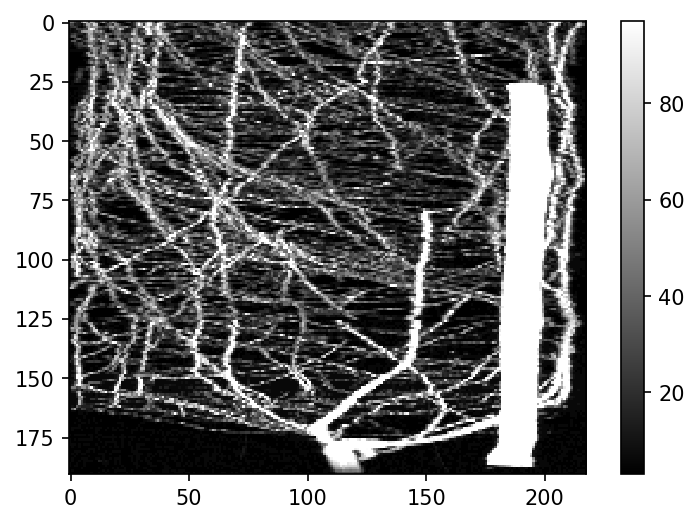

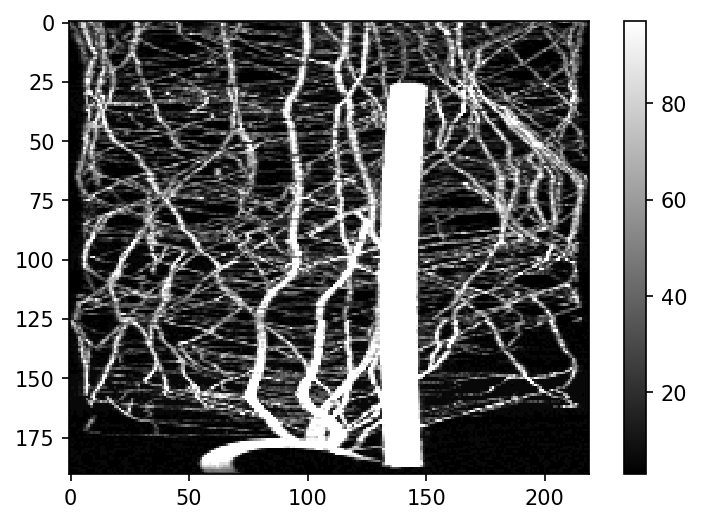

In [5]:
# plot_merged_slices(mri[:,:,15:241], 'x', 0, 250)
# plot_merged_slices(mri[:,17:236,:], 'y', 0, 250)
# plot_merged_slices(mri[:10,12:238,15:243], 'z', 0, 10)

# :,:,:
plot_merged_slices(mri[:,:,24:242], 'x', 0, 250)
plot_merged_slices(mri[:,15:234,:], 'y', 0, 250)


### Calculate the voxelization params accordingly

In [6]:
# min_x: -5.7412 max_x: 29.067
# min_y: -30.468 max_y: 26.029
# min_z: -51.881 max_z: -0.26482

min_rootsys_xyz = [min_x, min_y, min_z]
max_rootsys_xyz = [max_x, max_y, max_z]
min_mri_xyz = [15, 24, 0]
max_mri_xyz = [234, 242, 191]
mri_range_xyz = [256, 256, 191]

bound_list_xyz = []
trans_list_xyz = []
for i in range(3):
    max_rootsys = max_rootsys_xyz[i]
    min_rootsys = min_rootsys_xyz[i]
    max_mri = max_mri_xyz[i]
    min_mri = min_mri_xyz[i]
    mri_range = mri_range_xyz[i]
    bound_rootsys = (max_rootsys-min_rootsys)*mri_range/(max_mri-min_mri)
    print('max bound param of rootsys:', bound_rootsys)
    bound_list_xyz.append(bound_rootsys)
    translation = min_mri/mri_range*bound_rootsys-min_rootsys
    print('translation:', translation)
    trans_list_xyz.append(translation)

print('bound_list_xyz:', bound_list_xyz)
print('trans_list_xyz:', trans_list_xyz)

max bound param of rootsys: 70.4444200913242
translation: 18.504602739726028
max bound param of rootsys: 70.84506422018349
translation: 36.5457247706422
max bound param of rootsys: 192.54007
translation: 192.19
bound_list_xyz: [70.4444200913242, 70.84506422018349, 192.54007]
trans_list_xyz: [18.504602739726028, 36.5457247706422, 192.19]


### Run voxelization (using the above found params)

In [267]:
os.chdir('/home/user/zhaoy/git/modify_data_augmentation/plant-root-MRI-display/voxellization')
root_name = 'Lupine_22august'
trans_x, trans_y, trans_z = trans_list_xyz
bound_x, bound_y, bound_z = bound_list_xyz
data_type = 'xml'  # 'root_sys'
fact = 129
depth_axis = 'x'

# %run -i voxellizer.py $trans_x $trans_y $trans_z $bound_x $bound_y $bound_z $root_name $mri_dim_x $mri_dim_y $mri_dim_z
# %run -i voxellizer.py $trans_x 34 $trans_z $bound_x $bound_y 195 $root_name $mri_dim_x $mri_dim_y $mri_dim_z
%run -i voxellizer.py 63.8951 49.9 49.738153381347656 129.4582935 99.8046875 99.8046875 $root_name 120 256 256 $data_type $fact $depth_axis



sys.argv[1:11]: ['63.8951', '49.9', '49.738153381347656', '129.4582935', '99.8046875', '99.8046875', 'Lupine_22august', '120', '256', '256']
voxellization_params: ['Lupine_22august', [720, 512, 512], 'x', 1.0, [63.8951, 49.9, 49.73815338134766], [0, 0, 0], [129.4582935, 99.8046875, 99.8046875], 129.0, 1, 0, 0, <__main__.StreamTee object at 0x7f80d9259400>, 'xml']
data_type: xml
xmax, xmin, ymax, ymin, zmax, zmin: 99.8046875 0 99.8046875 0 129.4582935 0
dim 123: [512, 512, 720]
shape of occupancy: (512, 512, 720)

0:  1/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 1575
num of voxels in current_branch_occupancy < 0: 25857877
max/min of current_branch_occupancy: 14.212585303811483 -2.0
0:  2/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 89
num of voxels in current_branch_occupancy < 0: 1189459
max/min of current_branch_occupancy: 12.39718067240882 -2.0
0:  3/100rectifying current_branch_occupancy
num of vox

0: 38/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 100
num of voxels in current_branch_occupancy < 0: 769089
max/min of current_branch_occupancy: 16.074215812012028 -2.0
0: 39/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 1
num of voxels in current_branch_occupancy < 0: 583143
max/min of current_branch_occupancy: 10.263728986476698 -2.0
0: 40/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 5
num of voxels in current_branch_occupancy < 0: 601621
max/min of current_branch_occupancy: 10.630207120019424 -2.0
0: 41/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 71
num of voxels in current_branch_occupancy < 0: 1018715
max/min of current_branch_occupancy: 16.345384359211707 -2.0
0: 42/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 102
num of voxels in current_branch_occupancy < 0: 1190407
max/

0: 77/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 43
num of voxels in current_branch_occupancy < 0: 758430
max/min of current_branch_occupancy: 11.845955326638785 -2.0
0: 78/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 97
num of voxels in current_branch_occupancy < 0: 1204385
max/min of current_branch_occupancy: 13.903893323194984 -2.0
0: 79/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 22
num of voxels in current_branch_occupancy < 0: 879612
max/min of current_branch_occupancy: 13.923502546104672 -2.0
0: 80/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 2
num of voxels in current_branch_occupancy < 0: 453206
max/min of current_branch_occupancy: 10.137820276944279 -2.0
0: 81/100rectifying current_branch_occupancy
num of voxels in current_branch_occupancy > 10: 235
num of voxels in current_branch_occupancy < 0: 5406321
max/

In [20]:
os.chdir('/home/user/zhaoy/git/modify_data_augmentation/plant-root-MRI-display/voxellization')
root_name = 'final/I_Soil_4D/DAP25'
# trans_x, trans_y, trans_z = trans_list_xyz
# bound_x, bound_y, bound_z = bound_list_xyz
data_type = 'root_sys'  # 'root_sys'
fact = 1
depth_axis = 'z'

# %run -i voxellizer.py $trans_x $trans_y $trans_z $bound_x $bound_y $bound_z $root_name $mri_dim_x $mri_dim_y $mri_dim_z
# %run -i voxellizer.py $trans_x 34 $trans_z $bound_x $bound_y 195 $root_name $mri_dim_x $mri_dim_y $mri_dim_z
%run -i voxellizer.py 18.504602739726028 34.0 192.19 70.4444200913242 70.84506422018349 195.0 $root_name 256 256 191 $data_type $fact $depth_axis


# ['I_Soil_4D/DAP25', [256, 256, 191], 'z', 1.0, [18.504602739726028, 34.0, 192.19], [0, 0, 0], [70.4444200913242, 70.84506422018349, 195.0]
'''
voxellization_params = [dataset_name, [int(resolution[i] * res_mult_fac) for i in range(3)], depth_axis,
                        radius_multiplier, translation, bound_start, bound_end, fact, depth_fact, z_rotation,
                        ctr, double_stream, data_type]
'''

sys.argv[1:11]: ['18.504602739726028', '34.0', '192.19', '70.4444200913242', '70.84506422018349', '195.0', 'final/I_Soil_4D/DAP25', '256', '256', '191']
voxellization_params: ['final/I_Soil_4D/DAP25', [512, 512, 1146], 'z', 1.0, [18.504602739726028, 34.0, 192.19], [0, 0, 0], [70.4444200913242, 70.84506422018349, 195.0], 1.0, 1, 0, 0, <__main__.StreamTee object at 0x7f2b76bca3c8>, 'root_sys']
data_type: root_sys
xmax, xmin, ymax, ymin, zmax, zmin: 70.4444200913242 0 70.84506422018349 0 195.0 0
dim 123: [512, 512, 1146]
shape of occupancy: (512, 512, 1146)

0: 134/134before py_block_reduce mean
before py_block_reduce mean
Volume created in 185.50296258926392
Volume final/I_Soil_4D/DAP25:0 creation took 185.52747464179993 seconds.
Total time used: 186.47560214996338


'\nvoxellization_params = [dataset_name, [int(resolution[i] * res_mult_fac) for i in range(3)], depth_axis,\n                        radius_multiplier, translation, bound_start, bound_end, fact, depth_fact, z_rotation,\n                        ctr, double_stream, data_type]\n'

### Make the voxelized images match the real mri image

In [21]:
output_dir = '/home/user/zhaoy/root_mri/experiments/voxellization_experiments/final/I_Soil_4D/DAP25/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0'
flip_z = True
swap_xy = False

# do the same to all files in the output directory
for fn in os.listdir(output_dir):
    if fn.endswith('.npz'):
        print('filename:', fn)
        img = np.load(join(output_dir, fn))['arr_0']
        print('    old shape:', img.shape)
        if flip_z == True:
            img = np.flip(img, axis=2)
        if swap_xy == True:
            img = np.swapaxes(img, 0, 1)
        print('    new shape:', img.shape)
        np.savez(join(output_dir, fn), img)

filename: original_512x512x1146_intensity.npz
    old shape: (512, 512, 1146)
    new shape: (512, 512, 1146)
filename: intensity_1x_aliased_256x256x191.npz
    old shape: (256, 256, 191)
    new shape: (256, 256, 191)
filename: intensity_1x_antialiased_256x256x191.npz
    old shape: (256, 256, 191)
    new shape: (256, 256, 191)
filename: intensity_2x_res_512x512x382.npz
    old shape: (512, 512, 382)
    new shape: (512, 512, 382)
filename: original_512x512x1146_occupancy.npz
    old shape: (512, 512, 1146)
    new shape: (512, 512, 1146)
filename: occ_1x_antialiased_256x256x191.npz
    old shape: (256, 256, 191)
    new shape: (256, 256, 191)
filename: occ_1x_aliased_256x256x191.npz
    old shape: (256, 256, 191)
    new shape: (256, 256, 191)
filename: occ_2x_res_512x512x382.npz
    old shape: (512, 512, 382)
    new shape: (512, 512, 382)


In [219]:
print('root_name:', root_name)
file_dir='/home/user/zhaoy/root_mri/experiments/voxellization_experiments/{}/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0/'.format(root_name)
file_name = '256x256x191_occupancy.npz'
# file_name = '128x128x100_occupancy.npz'
reshape_and_save(file_dir, file_name)


root_name: I_Soil_4D/DAP25
(256, 256, 191)
(191, 1, 256, 256)


'/home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_4D/DAP25/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0/191x1x256x256_occupancy.npz'

In [84]:
### If necessary: flip the mri image:
print('mri_path:', mri_path)
mri = np.load(mri_path).astype(np.float32)
mri = np.flip(mri,  axis=0)
np.save(mri_path, mri)

mri_path: /home/user/zhaoy/root_mri/experiments/voxellization_experiments/I_Soil_1W/DAP32/I_Soil_1W_DAP32_206x1x256x256_uint8.npy


### Automatically try other possible param combinations

In [241]:
print(root_name)

I_Soil_1W_DAP19


In [265]:
file_dir='/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/{}/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0/'.format(root_name)
file_name = '256x256x200_occupancy.npz'
# file_name = '128x128x100_occupancy.npz'
mri_path = '/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/{}/I_Soil_1W_DAP19_200x1x256x256_uint8.npy'.format(root_name)
new_occ_path = reshape_and_save(file_dir, file_name)
np.savez_compressed(new_occ_path, np.flip(np.load(new_occ_path)['arr_0'], axis=0))  # flip the z axis
compute_occ_mri_overlap(new_occ_path, mri_path)

# trans_x_list = []
# trans_y_list = []
# trans_z_list = []
# bound_end_x_list = []
# bound_end_y_list = []
# bound_end_z_list = []
# overlap_list = []


# for trans_x in (41.90, 42.5):
#     for trans_y in (36.01, 36.5):
#         for trans_z in (2.6, 3.0):
#             for bound_end_x in (68.2, 68.67, 69.0):
#                 for bound_end_y in (71.5, 72, 72.5):
#                     for bound_end_z in (134.15, 134.5):
#                         os.chdir('/home/stud/zhaoy/git/modify_data_augmentation/plant-root-MRI-display/voxellization')
#                         %run -i voxellizer.py $trans_x $trans_y $trans_z $bound_end_x $bound_end_y $bound_end_z $root_name $mri_dim_x $mri_dim_y $mri_dim_z
                        
#                         new_occ_path = reshape_and_save(file_dir, file_name)
#                         np.savez_compressed(new_occ_path, np.flip(np.load(new_occ_path)['arr_0'], axis=0))  # flip z axis
#                         overlap_list.append(compute_occ_mri_overlap(new_occ_path, mri_path))
#                         trans_x_list.append(trans_x)
#                         trans_y_list.append(trans_y)
#                         trans_z_list.append(trans_z)
#                         bound_end_x_list.append(bound_end_x)
#                         bound_end_y_list.append(bound_end_y)
#                         bound_end_z_list.append(bound_end_z)
                        
                        


(256, 256, 200)
(200, 1, 256, 256)


3587.0247933884334

### Report the param combination with the highest overlapping between voxelized result and real MRI image

In [139]:
print('Highest overlap score:',np.array(overlap_list).max())
overlap_list = np.array(overlap_list)
overlap_list = np.expand_dims(overlap_list, axis=1)
trans_x_list = np.array(trans_x_list)
trans_x_list = np.expand_dims(trans_x_list, axis=1)
trans_y_list = np.array(trans_y_list)
trans_y_list = np.expand_dims(trans_y_list, axis=1)
trans_z_list = np.array(trans_z_list)
trans_z_list = np.expand_dims(trans_z_list, axis=1)
bound_end_x_list = np.array(bound_end_x_list)
bound_end_x_list = np.expand_dims(bound_end_x_list, axis=1)
bound_end_y_list = np.array(bound_end_y_list)
bound_end_y_list = np.expand_dims(bound_end_y_list, axis=1)
bound_end_z_list = np.array(bound_end_z_list)
bound_end_z_list = np.expand_dims(bound_end_z_list, axis=1)

table = np.concatenate((overlap_list, trans_x_list, trans_y_list, 
                        trans_z_list, bound_end_x_list, bound_end_y_list, bound_end_z_list), axis=1)
print(table.shape)
print('Params with the highest overlap score:', np.squeeze(table[table[:,0]==table[:,0].max()]))


Highest overlap score: 590.2882882882886
(144, 7)
Params with the highest overlap score: [590.28828829  41.9         36.5          2.6         69.
  71.5        134.5       ]


In [146]:
table[(table[:,1]==41.90)&(table[:,2]==36.01)&(table[:,3]==2.6)&(table[:,4]==68.2)&(table[:,5]==71.5)&(table[:,6]==134.15),0]


array([441.72972973])

### Write the best param combination to file

In [61]:
path = '/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/I_Sand_3D_DAP13/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0/198x1x256x256_occupancy.npz'
img = np.load(path)['arr_0']
img = np.squeeze(img)
print(img.shape)


(198, 256, 256)


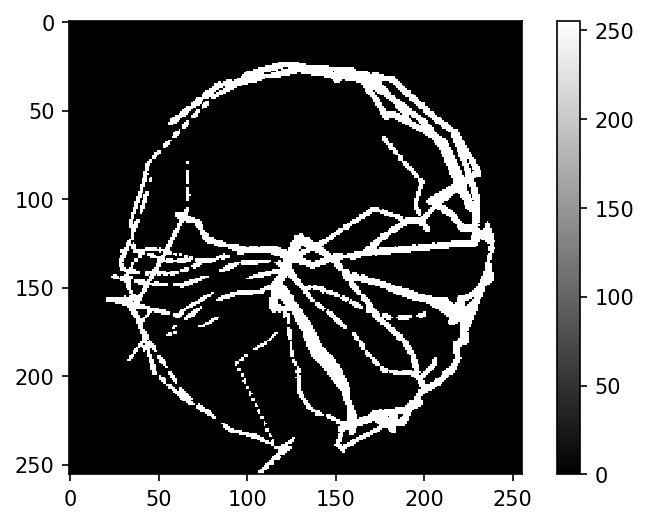

In [65]:
plot_merged_slices(img, 'z', 0, 255)

(198, 256, 256)


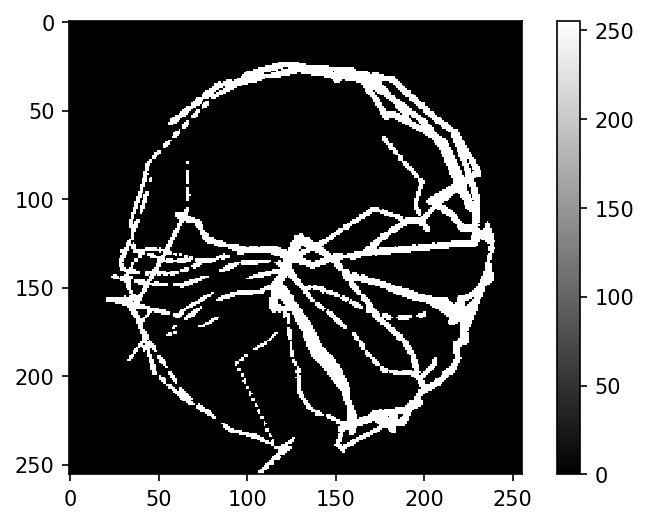

In [66]:
path = '/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/I_Sand_3D_DAP13/r_factor_1.00/rot_0/x_flip_0/y_flip_0/x_y_swap_0/198x1x256x256_occupancy3.npz'
img = np.load(path)['arr_0']
img = np.squeeze(img)
print(img.shape)
plot_merged_slices(img, 'z', 0, 255)

(198, 256, 256)


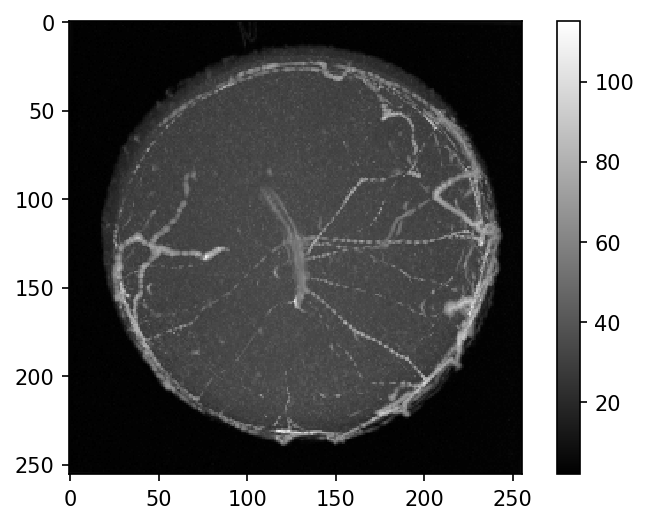

In [71]:
path = '/home/stud/zhaoy/root_mri/experiments/voxellization_experiments/I_Sand_3D_DAP13/I_Sand_3D_DAP13_198x1x256x256_uint8_xyswapped.npy'
img = np.load(path)
img = np.squeeze(img)
print(img.shape)
plot_merged_slices(img, 'z', 0, 255)

In [76]:
np.cos(np.deg2rad(60))

0.5000000000000001